In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm

from build_corpus import build_corpus
from build_vocab import WordVocab
from utils import split

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import rdkit
import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import wandb
from rdkit.Chem import Draw
from rdkit.Chem import MolFromSmiles


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home2/bhuvan.kapur/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.5.0) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [3]:
df = pd.read_csv('../data/lck_dockstring_data.csv')

In [4]:
import sklearn
# minmaxscaler
from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# df['qeds'] = scaler.fit_transform(df['qeds'].values.reshape(-1,1))
# df['tpsas'] = scaler.fit_transform(df['tpsas'].values.reshape(-1,1))
# df['logps'] = scaler.fit_transform(df['logps'].values.reshape(-1,1))
# df['affinity'] = scaler.fit_transform(df['affinity'].values.reshape(-1,1))

affinity_scaler = MinMaxScaler()
qed_scaler = MinMaxScaler()
logp_scaler = MinMaxScaler()
tpsas_scaler = MinMaxScaler()

affinity_scaler.fit(df['affinity'].values.reshape(-1,1))
qed_scaler.fit(df['qeds'].values.reshape(-1,1))
logp_scaler.fit(df['logps'].values.reshape(-1,1))
tpsas_scaler.fit(df['tpsas'].values.reshape(-1,1))

df['qeds'] = qed_scaler.transform(df['qeds'].values.reshape(-1,1))
df['logps'] = logp_scaler.transform(df['logps'].values.reshape(-1,1))
df['tpsas'] = tpsas_scaler.transform(df['tpsas'].values.reshape(-1,1))
df['affinity'] = affinity_scaler.transform(df['affinity'].values.reshape(-1,1))


In [4]:
# df = pd.read_csv('../data/DOCKSTRING/target_specific/LCK.csv')

In [5]:
SMI_MAX_SIZE= -1
with open('../data/smiles_corpus.txt', 'w') as f:
    train = []
    test = []        
    for i, row in df.iterrows():
        if row['split'] == "test":
            test.append(list(row.values))
        else:
            train.append(list(row.values))
        f.write(split(row['smiles'] +'\n'))
        
        if SMI_MAX_SIZE < len(row['smiles']):
            SMI_MAX_SIZE = len(row['smiles'])
f.close()
print("SMI_MAX_SIZE ", SMI_MAX_SIZE)
train_df = pd.DataFrame(train, columns=df.columns)
test_df = pd.DataFrame(test, columns=df.columns)

SMI_MAX_SIZE  254


In [6]:
SMI_MAX_SIZE = 300
SMI_MIN_FREQ=1
with open("../data/DOCKSTRING/smiles_corpus.txt", "r") as f:
    smiles_vocab = WordVocab(f, max_size=SMI_MAX_SIZE, min_freq=SMI_MIN_FREQ)

Building Vocab


In [7]:

class CustomTargetDataset(Dataset):
    def __init__(self, dataframe, SmilesVocab, properties_list):
        self.dataframe = dataframe
        self.smiles_vocab = SmilesVocab
        self.property_list = properties_list
        self.build()
        
    def build(self):
        smiles, properties, affinities= [],[],[]
        smiles_encoding = []
        for i, row in self.dataframe.iterrows():
            smi = row['smiles']
            # newsmi = Chem.MolToSmiles(Chem.MolFromSmiles(smi))
            newsmi = smi
            smiles.append(newsmi)
            smiles_encoding.append(self.smiles_vocab.to_seq(split(newsmi), seq_len=SMI_MAX_SIZE))
            props = []
            for p in self.property_list:
                props.append(row[p])
            properties.append(props)

        self.smiles_encodings = torch.tensor(smiles_encoding)
        self.properties = torch.tensor(properties)
        # self.affinities = torch.tensor(affinities)
        print("dataset built")
        
    def __len__(self):
        return len(self.properties)
    
    def __getitem__(self, index):
        return {
            "smiles_rep": self.smiles_encodings[index],
            "properties": self.properties[index],
        }

In [8]:
class PositionalEncodings(nn.Module):
    """Attention is All You Need positional encoding layer"""

    def __init__(self, seq_len, d_model, p_dropout,n=10000):
        """Initializes the layer."""
        super(PositionalEncodings, self).__init__()
        token_positions = torch.arange(start=0, end=seq_len).view(-1, 1)
        dim_positions = torch.arange(start=0, end=d_model).view(1, -1)
        angles = token_positions / (n ** ((2 * dim_positions) / d_model))

        encodings = torch.zeros(1, seq_len, d_model)
        encodings[0, :, ::2] = torch.cos(angles[:, ::2])
        encodings[0, :, 1::2] = torch.sin(angles[:, 1::2])
        encodings.requires_grad = False
        self.register_buffer("positional_encodings", encodings)

        self.dropout = nn.Dropout(p_dropout)

    def forward(self, x):
        """Performs forward pass of the module."""
        x = x + self.positional_encodings[:,:x.shape[1],:]
        x = self.dropout(x)
        return x

In [9]:
class PropertyEncoder(nn.Module):
    def __init__(self, d_model, n_properties):
        super(PropertyEncoder, self).__init__()
        self.layer = nn.Linear(n_properties, d_model)
        self.layer_final = nn.Linear(d_model, d_model)
    def forward(self, x):
        return self.layer_final(self.layer(x))

In [10]:
def set_up_causal_mask(seq_len):
    mask = (torch.triu(torch.ones(seq_len, seq_len)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    mask.requires_grad = False
    return mask

In [11]:
class SmileDecoder(nn.Module):
    def __init__(self, d_model, n_heads, n_layers, vocab, n_properties, hidden_units=1024, dropout=0.1):
        super(SmileDecoder, self).__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.n_layers = n_layers
        self.vocab = vocab
        self.dropout = dropout
        
        self.embed = nn.Embedding(len(vocab), d_model)
        self.smile_pe = PositionalEncodings(SMI_MAX_SIZE, d_model, dropout)
        
        self.trfmLayer = nn.TransformerEncoderLayer(d_model=d_model,
                                                    nhead=n_heads,
                                                    dim_feedforward=hidden_units,
                                                    dropout=dropout,
                                                    batch_first=True,
                                                    norm_first=True,
                                                    activation="gelu")
        self.trfm = nn.TransformerEncoder(encoder_layer=self.trfmLayer,
                                          num_layers=n_layers,
                                          norm=nn.LayerNorm(d_model))
        self.ln_f = nn.LayerNorm(d_model)
        self.classifier = nn.Linear(d_model, len(vocab))
        self.property_encoder = PropertyEncoder(d_model,n_properties=n_properties)
        
    def forward(self, x, property):
        property = self.property_encoder(property).unsqueeze(1)
        
        x = self.embed(x)
        x = self.smile_pe(x)
        
        x = torch.cat([property, x], dim=1).to(x.device)
        
        mask = set_up_causal_mask(x.shape[1]).to(device)
        x = self.trfm(src=x,
                      mask=mask,
                      )
        x = self.ln_f(x)
        x = self.classifier(x)
        return x

In [12]:
# import nn.utils.clip_grad_value_
def train_step(model, data_loader, optimizer,epoch):
    running_loss = []
    model.to(device)
    model.train()
    for i, data in enumerate(data_loader):
        data = {k: v.to(device) for k, v in data.items()}
        
        optimizer.zero_grad()
        out = model(data['smiles_rep'], data['properties'])
        out = out[:,:-1,:]
        
        loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),data['smiles_rep'].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        nn.utils.clip_grad_value_(model.parameters(), clip_value=1.0)
        running_loss.append(loss.item())
        print( 'Training Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)
        
def val_step(model, data_loader, epoch):
    running_loss = []
    model.to(device)
    model.eval()
    with torch.no_grad():
        for i, data in enumerate(data_loader):
            data = {k: v.to(device) for k, v in data.items()}
            out = model(data['smiles_rep'], data['properties'])
            out = out[:,:-1,:]
            
            loss = F.cross_entropy(out.contiguous().view(-1, len(smiles_vocab)),data['smiles_rep'].contiguous().view(-1))
            running_loss.append(loss.item())
            print( 'Validating Epoch: {} | iteration: {}/{} | Loss: {}'.format(epoch, i, len(data_loader), loss.item() ), end='\r')
        
    return np.mean(running_loss)


In [13]:
class Sampler:
    def __init__(self, model, vocab):
        self.model = model.module
        self.vocab = vocab
        
    def sample(self, properties, greedy=False):
        samples = []
        with torch.no_grad():
            property = properties.to(device)
            # print(property.shape)
            smiles_seq = torch.full((property.shape[0], 1), self.vocab.stoi["<sos>"]).long().to(device)
            # print(smiles_seq.shape)
            
            for i in range(SMI_MAX_SIZE):
                logits = self.model.forward(smiles_seq, property)
                # print("logits", logits.shape)
                probs = F.softmax(logits[:,-1], dim= -1)
                # print(probs.shape)
                # break
                if greedy:
                    pred_id = torch.argmax(probs, dim= -1)
                    pred_id = pred_id.unsqueeze(1)
                else:
                    pred_id = torch.multinomial(probs, num_samples=1)
                # print(pred_id.shape)
                # break
                smiles_seq = torch.cat([smiles_seq, pred_id], dim=1)
                
                # break
            for i in range(len(smiles_seq)):
                smile = self.vocab.from_seq(smiles_seq[i].cpu().numpy())
                final_smile = ""
                for char in smile:
                    if char == "<end>" or char == "<pad>" or char =="<sos>":
                        continue
                    final_smile += char
                samples.append(final_smile)
        return samples

In [14]:
def sample_a_bunch(model, dataloader, greedy=False):
    sampler = Sampler(model, smiles_vocab)
    model.eval()
    samples = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            samples += smiles
            print(i, end='\r')
            if len(samples) >= 1000:
                break
    return samples

In [15]:
import os
import yaml

def save_model(model, config):
    path_dir = '../checkpoints/'+ config['run_name']
    if not os.path.exists(path_dir):
        os.mkdir(path_dir)
    model_path = path_dir + '/' + 'model' + '.pt'
    config_path = path_dir + '/config.yaml'
    torch.save(model.state_dict(), model_path)
    with open(config_path,'w') as yaml_file:
        yaml.dump(dict(config), yaml_file)
        

In [17]:
# columns = ['smiles', 'affinity', 'logps', 'qeds', 'tpsas', 'split']
config = {
    'batch_size' :512,
    'd_model': 512,
    'n_heads': 8,
    'n_layers':4,
    'hidden_units': 1024,
    'lr': 1e-5,
    'epochs': 200,
    'properties': sorted(['affinity', 'logps','tpsas', 'qeds'])
}
config['run_name'] = "_".join(prop for prop in config['properties'])
print(config)

{'batch_size': 512, 'd_model': 512, 'n_heads': 8, 'n_layers': 4, 'hidden_units': 1024, 'lr': 1e-05, 'epochs': 200, 'properties': ['affinity', 'logps', 'qeds', 'tpsas'], 'run_name': 'affinity_logps_qeds_tpsas'}


In [19]:
def load_model(config):
    path_dir = '../checkpoints/'+ config['run_name']
    model_path = path_dir + '/' + 'model' + '.pt'
    model = SmileDecoder(d_model=config['d_model'], 
                   n_heads=config['n_heads'], 
                   n_layers=config['n_layers'], 
                   vocab=smiles_vocab, 
                   n_properties=len(config['properties']), 
                   hidden_units=config['hidden_units'],
                   dropout=0.1)
    
    optimizer = torch.optim.AdamW(model.parameters(), lr=config['lr'])
    model.to(device)
    num_gpus = torch.cuda.device_count()
    print("No of GPUs available", num_gpus)

    model = torch.nn.parallel.DataParallel(model)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

In [20]:
model = load_model(config)

No of GPUs available 1


In [21]:
test_dataset = CustomTargetDataset(test_df, smiles_vocab, properties_list=config['properties'])

dataset built


In [22]:
test_loader = DataLoader(test_dataset, batch_size=config['batch_size'], shuffle=True)

In [23]:
def sample_a_bunch(model, dataloader, greedy=False):
    sampler = Sampler(model, smiles_vocab)
    model.eval()
    samples = []
    properties = []
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            # data = {k: v.to(device) for k, v in data.items()}
            smiles = sampler.sample(data['properties'].to(device), greedy=greedy)
            properties += data['properties'].cpu().numpy().tolist()
            samples += smiles
            print(i, end='\r')
            if len(samples) >= 1000:
                break
    return np.array(properties), samples

In [24]:
properties, samples = sample_a_bunch(model, test_loader)


In [25]:
df = pd.DataFrame({"SMILES":samples})
properties = np.array(properties)
for i, property_name in enumerate(config['properties']):
    df["input_" + property_name] = properties[:,i]

df.to_csv('../checkpoints/'+config['run_name']+'/sampled_mols.csv')

In [26]:
from rdkit import Chem
def calculate_validity_rate(smiles_list):
    valid_count = 0
    total_count = len(smiles_list)

    for smiles in smiles_list:
        mol = Chem.MolFromSmiles(smiles)
        if mol is not None:
            valid_count += 1

    validity_rate = valid_count / total_count
    return validity_rate

In [27]:
from rdkit.Chem import RDConfig
import os
import sys
sys.path.append(os.path.join(RDConfig.RDContribDir, 'SA_Score'))
# now you can import sascore!
import sascorer
from rdkit.Chem import QED, Descriptors, Crippen
def calc_properties(properties, smiles):
    qeds = []
    logps = []
    tpsas = []
    sas = []
    molwt = []
    props = []
    valid_smi = []
    for prop,smi in zip(properties,smiles):
        mol = Chem.MolFromSmiles(smi)
        try:
            if mol is not None:
                qed = QED.qed(mol)
                logp = Crippen.MolLogP(mol)
                tpsa = Descriptors.TPSA(mol)
                sa = sascorer.calculateScore(mol)
                mw = Descriptors.MolWt(mol)
                
                qeds.append(qed)
                logps.append(logp)
                tpsas.append(tpsa)
                sas.append(sa)
                molwt.append(mw)
                props.append(prop)    
                valid_smi.append(smi)            
        except:
            pass
                
    return qeds, logps, tpsas, sas, molwt, np.array(props), valid_smi

In [ ]:
print("validity rate", calculate_validity_rate(samples))

In [29]:
qeds, logps, tpsas, sas, molwt , og_props,valsmi = calc_properties(properties, samples)

In [31]:
og_logp = og_props[:,1]
og_tpsa = og_props[:,3]

In [32]:
import seaborn as sns

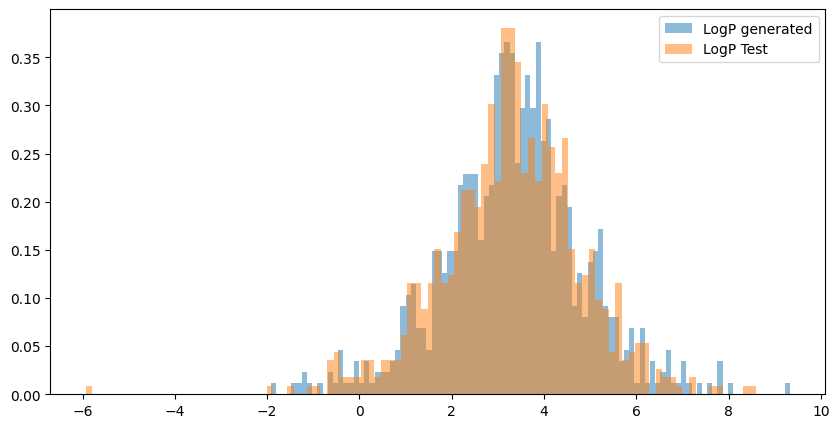

In [33]:
#histogram density plot using matplotlib
plt.figure(figsize=(10,5))
plt.hist(logps, bins=100, density=True, alpha=0.5, label='LogP generated')
plt.hist(logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='LogP Test')
plt.legend(loc='upper right')

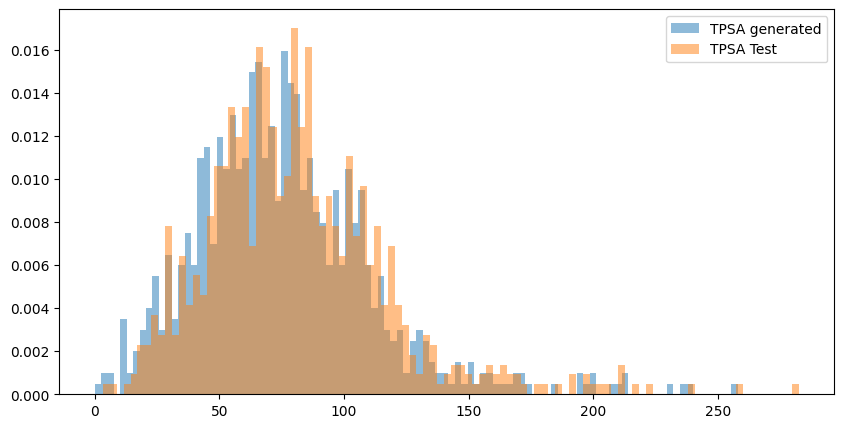

In [34]:
#histogram density plot using matplotlib
plt.figure(figsize=(10,5))
plt.hist(tpsas, bins=100, density=True, alpha=0.5, label='TPSA generated')
plt.hist(tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten(), bins=100, density=True, alpha=0.5, label='TPSA Test')
plt.legend(loc='upper right')

In [35]:
stats = pd.DataFrame({ "LogP_pred":logps, "tpsa_pred":tpsas})
stats['TPSA_og'] = tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten()
stats['LogP_og'] = logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten()


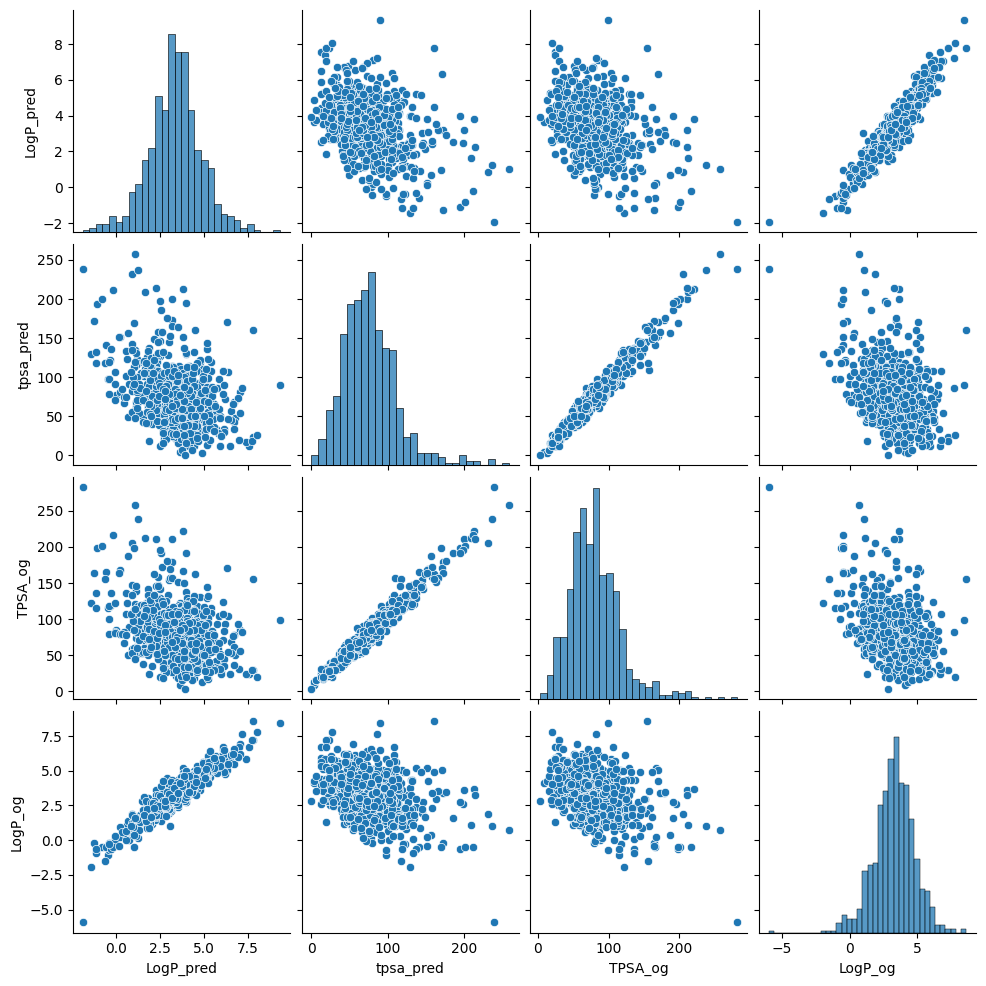

In [37]:
sns.pairplot(stats)

In [38]:
diff_logp = abs(np.array(logps) - logp_scaler.inverse_transform(og_logp.reshape(-1,1)).flatten())
diff_tpsa = abs(np.array(tpsas) - tpsas_scaler.inverse_transform(og_tpsa.reshape(-1,1)).flatten())

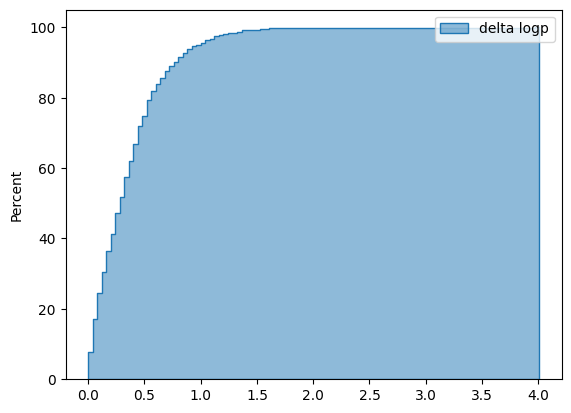

In [39]:
sns.histplot(data=diff_logp, stat="percent",label='delta logp', bins=100, element="step", cumulative=True, alpha=0.5)
plt.legend()

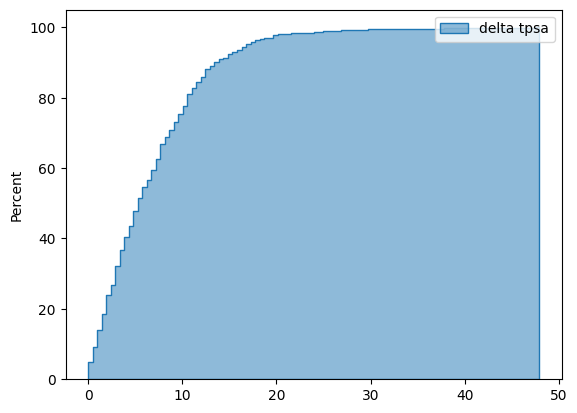

In [40]:
sns.histplot(data=diff_tpsa, stat="percent",label='delta tpsa', bins=100, element="step", cumulative=True, alpha=0.5)
plt.legend()

In [66]:
target_props = {}
target_props['affinity'] = [-8]
target_props['logp'] = [ 2, 3,4]
target_props['qeds'] = [0.8]
target_props['tpsas'] = [100]

In [67]:
queries = []
property_vectors = []
for a in target_props['affinity']:
    for b in target_props['logp']:
        for c in target_props['qeds']: 
            for d in target_props['tpsas']:
                key = str(a)+'-'+str(b)+'-'+str(c) + '-' + str(d)
                t = torch.Tensor([
                    affinity_scaler.transform([[a]]).flatten()[0],
                    logp_scaler.transform([[b]]).flatten()[0],
                    qed_scaler.transform([[c]]).flatten()[0],
                    tpsas_scaler.transform([[d]]).flatten()[0]
                    ])
                queries.append(key)
                property_vectors.append(t)
property_vectors = torch.stack(property_vectors)   

In [68]:
sampler = Sampler(model, smiles_vocab)

In [69]:
results = {}
count = 0
for key, v in zip(queries, property_vectors):
    print(key, v)
    p = v.repeat(2*config['batch_size'], 1)
    samples = sampler.sample(p, greedy=False)
    if key in results:
        print("duplicate key", key)
    qeds, logps, tpsas, sas, molwt , og_props, smi=calc_properties([-1]*len(samples),samples)
    results[key] = [logps, tpsas, qeds, samples]
    count += 1

-8-2-0.8-100 tensor([0.5714, 0.4638, 0.8424, 0.2011])


-8-3-0.8-100 tensor([0.5714, 0.5065, 0.8424, 0.2011])
-8-4-0.8-100 tensor([0.5714, 0.5491, 0.8424, 0.2011])


In [70]:
data = []
columns = ['target_TPSA', 'target_logp', 'predicted_TPSA', 'predicted_logp', 'TPSA-logp', 'key']
for key in results:
    keys = key.split('-')
    logp = keys[2]
    tpsa = keys[4]
    for i in range(len(results[key][0])):
        data.append([tpsa, logp, results[key][1][i], results[key][0][i], str(tpsa)+'-'+str(logp), key])

In [71]:
import pickle
import pandas as pd
# dump results dictionary into a pickle file
with open('../checkpoints/affinity_logps_qeds_tpsas/results.pkl', 'wb') as f:
    pickle.dump(results, f)

with open('../checkpoints/affinity_logps_qeds_tpsas/results.pkl', 'rb') as f:
    results = pickle.load(f)

In [72]:
data = []
columns = ['target_TPSA', 'target_logp', 'predicted_TPSA', 'predicted_logp', 'TPSA-logp', 'key']
for key in results:
    keys = key.split('-')
    logp = keys[2]
    tpsa = keys[4]
    for i in range(len(results[key][0])):
        data.append([tpsa, logp, results[key][1][i], results[key][0][i], str(tpsa)+'-'+str(logp), key])

In [73]:
data_df = pd.DataFrame(data, columns=columns)

<AxesSubplot: xlabel='predicted_TPSA', ylabel='Density'>

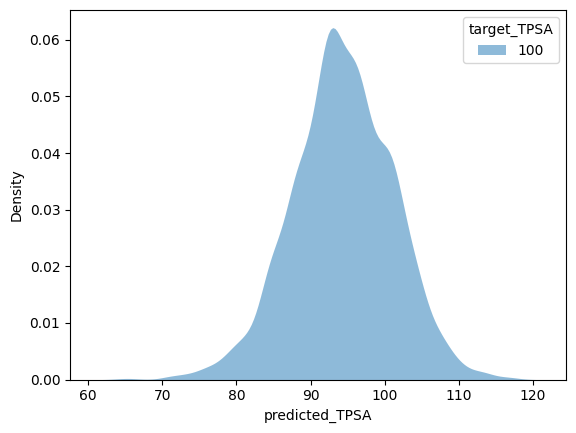

In [75]:
sns.kdeplot(data=data_df, x="predicted_TPSA",hue="target_TPSA", fill=True,alpha=.5, linewidth=0)

<AxesSubplot: xlabel='predicted_logp', ylabel='Density'>

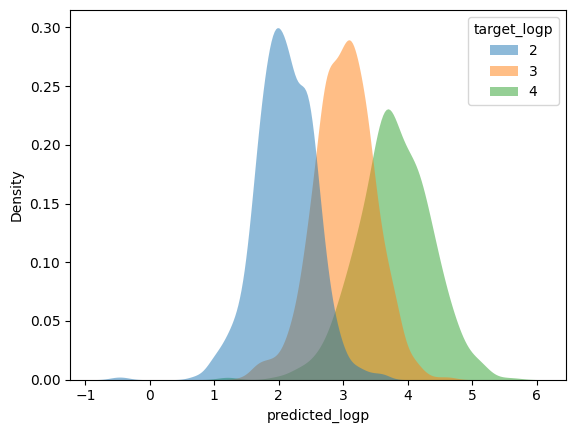

In [76]:
sns.kdeplot(data=data_df, x="predicted_logp",hue="target_logp", fill=True,alpha=.5, linewidth=0)

<AxesSubplot: xlabel='predicted_TPSA', ylabel='predicted_logp'>

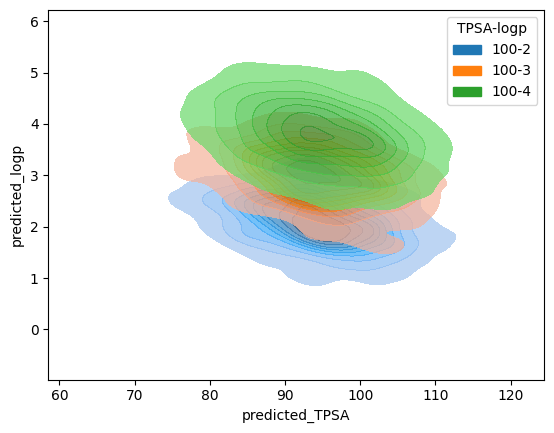

In [77]:
sns.kdeplot(data=data_df, x="predicted_TPSA", y="predicted_logp", hue="TPSA-logp", fill=True, alpha=0.7)
